## ['EfficientDet: Scalable and Efficient Object Detection'](https://link.zhihu.com/?target=https%3A//arxiv.org/abs/1911.09070v1)
- Google's paper in Nov 20th

no official open-source now, just find some repos.

https://github.com/toandaominh1997/EfficientDet.Pytorch

If you think it's useful, please give me an upvote.

## wonderful result :
![1](http://pics5.baidu.com/feed/c8177f3e6709c93d6cc3fbc78f4a2ad9d100544d.jpeg?token=989fe2e4ec45157cb9f0fa85fa9944e2&s=21B6ED3251AFF0EE1ED908C10000F0B3)

# Related Work
## 1. One-Stage Detectors :
**In this paper, we mainly follow the one-stage detector design, and we show it is possible to achieve both better efficiency and higher accuracy with optimized network architectures.**

## 2. Multi-Scale Feature Representations :
**we first formulate the multi-scale feature fusion problem, and then introduce the two main ideas for our proposed BiFPN: efficient bidirectional cross-scale connections and weighted feature fusion.**

- structure :
![2](https://pic1.zhimg.com/80/v2-c5b7e0dcb2f455e2e4037e10922bbb50_hd.jpg)

- weighted feature fusion
![a](https://pic1.zhimg.com/80/v2-328a45d131dac4c7aefe0eddffbf0bcc_hd.jpg)

## 3. Model Scaling :
**Based on our BiFPN, we have developed a new family of detection models named EfficientDet. In this section, we will discuss the network architecture and a new compound scaling method for EfficientDet.**
![3](https://pic3.zhimg.com/80/v2-e89c42b5c07697837b2883b0174916da_hd.jpg)

## 4. Result :
- 1
![4](https://pic4.zhimg.com/80/v2-039b1197596fff9af09b55bb24b53e33_hd.jpg)

- 2
![5](http://pics2.baidu.com/feed/b7fd5266d016092498ca5cd7da70e7ffe4cd348f.png?token=5bf52f9beca3ddc6c420785935ee6994&s=2AAC7A22C4F1C988185DB1CB0000C0B1)

- 3
![6](http://pics4.baidu.com/feed/1c950a7b02087bf403c35afce2a4852911dfcf70.jpeg?token=36b5e37c58493aa8ee12e82cb817dce1&s=8D0EED1211CC48EA0CC9A1DA000080B2)

# How to build BiFPN ?
## 1. What's FPN?
[**Feature Pyramid Networks for Object Detection**](https://arxiv.org/abs/1612.03144)
![fpn](http://file.elecfans.com/web1/M00/59/BB/pIYBAFtqRd-AZlifAAAziaQTkYk948.png)


## 2. BiFPN
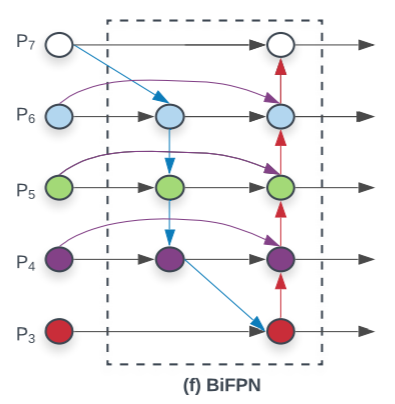

# EfficientNet backbone
## 1. What's EfficientNet?
[**EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks ICML 2019 **](https://arxiv.org/abs/1905.11946)

Tensorflow(official): https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet

Pytorch: https://github.com/lukemelas/EfficientNet-PyTorch

![efficientnet](https://img-blog.csdnimg.cn/20190607190809941.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly90cmVudC5ibG9nLmNzZG4ubmV0,size_16,color_FFFFFF,t_70)

# Demo

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils import model_zoo
from torchvision.ops import nms
from torchvision import transforms

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import skimage

import re
import collections
from functools import partial
import math
import pandas as pd
import numpy as np
from timeit import default_timer as timer
import copy
import albumentations as albu
from albumentations.pytorch.transforms import ToTensor
from six.moves import map, zip

### EfficientDet

utils

In [ ]:
########################################################################
############### HELPERS FUNCTIONS FOR MODEL ARCHITECTURE ###############
########################################################################


# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate',
    'num_classes', 'width_coefficient', 'depth_coefficient',
    'depth_divisor', 'min_depth', 'drop_connect_rate', 'image_size'])

# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'stride', 'se_ratio'])

# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)


class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""

    def __init__(self, in_channels, out_channels, kernel_size, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


class Identity(nn.Module):
    def __init__(self, ):
        super(Identity, self).__init__()

    def forward(self, input):
        return input


########################################################################
############## HELPERS FUNCTIONS FOR LOADING MODEL PARAMS ##############
########################################################################


def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """

    @staticmethod
    def _decode_block_string(block_string):
        """ Gets a block through a string notation of arguments. """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            stride=[int(options['s'][0])])

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """
        Decodes a list of string notations to specify blocks inside the network.
        :param string_list: a list of strings, each string is a notation of block
        :return: a list of BlockArgs namedtuples of block args
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """
        Encodes a list of BlockArgs to a list of strings.
        :param blocks_args: a list of BlockArgs namedtuples of block args
        :return: a list of strings, each string is a notation of block
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet(width_coefficient=None, depth_coefficient=None, dropout_rate=0.2,
                 drop_connect_rate=0.2, image_size=None, num_classes=1000):
    """ Creates a efficientnet model. """

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s22_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s22_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        # data_format='channels_last',  # removed, this is always true in PyTorch
        num_classes=num_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
        image_size=image_size,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


url_map = {
    'efficientnet-b0': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b7-dcc49843.pth',
}


def load_pretrained_weights(model, model_name, load_fc=True):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    state_dict = model_zoo.load_url(url_map[model_name])
    if load_fc:
        model.load_state_dict(state_dict)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        res = model.load_state_dict(state_dict, strict=False)
        assert set(res.missing_keys) == set(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
    print('Loaded pretrained weights for {}'.format(model_name))

EfficientNet

In [ ]:
class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block
    Args:
        block_args (namedtuple): BlockArgs, see above
        global_params (namedtuple): GlobalParam, see above
    Attributes:
        has_se (bool): Whether the block contains a Squeeze and Excitation layer.
    """

    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # skip connection and drop connect

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Expansion phase
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)
        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Output phase
        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._swish(self._bn0(self._expand_conv(inputs)))
        
        x = self._swish(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(self._swish(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()


class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods
    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks
    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')
    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)
        
        # Build blocks
        self._blocks = nn.ModuleList([])
        for i in range(len(self._blocks_args)):
            # Update block input and output filters based on depth multiplier.
            self._blocks_args[i] = self._blocks_args[i]._replace(
                input_filters=round_filters(self._blocks_args[i].input_filters, self._global_params),
                output_filters=round_filters(self._blocks_args[i].output_filters, self._global_params),
                num_repeat=round_repeats(self._blocks_args[i].num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(self._blocks_args[i], self._global_params))
            if self._blocks_args[i].num_repeat > 1:
                self._blocks_args[i] = self._blocks_args[i]._replace(input_filters=self._blocks_args[i].output_filters, stride=1)
            for _ in range(self._blocks_args[i].num_repeat - 1):
                self._blocks.append(MBConvBlock(self._blocks_args[i], self._global_params))

        # Head'efficientdet-d0': 'efficientnet-b0',
        in_channels = self._blocks_args[len(self._blocks_args)-1].output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(self._global_params.dropout_rate)
        self._fc = nn.Linear(out_channels, self._global_params.num_classes)
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)


    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """
        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        P = []
        index = 0 
        num_repeat = 0
         # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)
            num_repeat = num_repeat + 1
            if(num_repeat == self._blocks_args[index].num_repeat):
                num_repeat = 0
                index = index + 1
                P.append(x)
        return P

    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """
        # Convolution layers
        P = self.extract_features(inputs)
        return P
    
    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return cls(blocks_args, global_params)

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000, in_channels = 3):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000))
        if in_channels != 3:
            Conv2d = get_same_padding_conv2d(image_size = model._global_params.image_size)
            out_channels = round_filters(32, model._global_params)
            model._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        return model
    
    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000))

        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name, also_need_pretrained_weights=False):
        """ Validates model name. None that pretrained weights are only available for
        the first four models (efficientnet-b{i} for i in 0,1,2,3) at the moment. """
        num_models = 4 if also_need_pretrained_weights else 8
        valid_models = ['efficientnet-b'+str(i) for i in range(num_models)]
        if model_name not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))
    
    def get_list_features(self):
        list_feature = []
        for idx in range(len(self._blocks_args)):
            list_feature.append(self._blocks_args[idx].output_filters)
        
        return list_feature

conv_module

In [ ]:
def conv_ws_2d(input,
               weight,
               bias=None,
               stride=1,
               padding=0,
               dilation=1,
               groups=1,
               eps=1e-5):
    c_in = weight.size(0)
    weight_flat = weight.view(c_in, -1)
    mean = weight_flat.mean(dim=1, keepdim=True).view(c_in, 1, 1, 1)
    std = weight_flat.std(dim=1, keepdim=True).view(c_in, 1, 1, 1)
    weight = (weight - mean) / (std + eps)
    return F.conv2d(input, weight, bias, stride, padding, dilation, groups)

class ConvWS2d(nn.Conv2d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=1,
                 bias=True,
                 eps=1e-5):
        super(ConvWS2d, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias)
        self.eps = eps

    def forward(self, x):
        return conv_ws_2d(x, self.weight, self.bias, self.stride, self.padding,
                          self.dilation, self.groups, self.eps)
conv_cfg = {
    'Conv': nn.Conv2d,
    'ConvWS': ConvWS2d,
    # TODO: octave conv
}

def build_conv_layer(cfg, *args, **kwargs):
    """ Build convolution layer
    Args:
        cfg (None or dict): cfg should contain:
            type (str): identify conv layer type.
            layer args: args needed to instantiate a conv layer.
    Returns:
        layer (nn.Module): created conv layer
    """
    if cfg is None:
        cfg_ = dict(type='Conv')
    else:
        assert isinstance(cfg, dict) and 'type' in cfg
        cfg_ = cfg.copy()

    layer_type = cfg_.pop('type')
    if layer_type not in conv_cfg:
        raise KeyError('Unrecognized norm type {}'.format(layer_type))
    else:
        conv_layer = conv_cfg[layer_type]

    layer = conv_layer(*args, **kwargs, **cfg_)

    return layer

norm_cfg = {
    # format: layer_type: (abbreviation, module)
    'BN': ('bn', nn.BatchNorm2d),
    'SyncBN': ('bn', nn.SyncBatchNorm),
    'GN': ('gn', nn.GroupNorm),
    # and potentially 'SN'
}

def build_norm_layer(cfg, num_features, postfix=''):
    """ Build normalization layer
    Args:
        cfg (dict): cfg should contain:
            type (str): identify norm layer type.
            layer args: args needed to instantiate a norm layer.
            requires_grad (bool): [optional] whether stop gradient updates
        num_features (int): number of channels from input.
        postfix (int, str): appended into norm abbreviation to
            create named layer.
    Returns:
        name (str): abbreviation + postfix
        layer (nn.Module): created norm layer
    """
    assert isinstance(cfg, dict) and 'type' in cfg
    cfg_ = cfg.copy()

    layer_type = cfg_.pop('type')
    if layer_type not in norm_cfg:
        raise KeyError('Unrecognized norm type {}'.format(layer_type))
    else:
        abbr, norm_layer = norm_cfg[layer_type]
        if norm_layer is None:
            raise NotImplementedError

    assert isinstance(postfix, (int, str))
    name = abbr + str(postfix)

    requires_grad = cfg_.pop('requires_grad', True)
    cfg_.setdefault('eps', 1e-5)
    if layer_type != 'GN':
        layer = norm_layer(num_features, **cfg_)
        if layer_type == 'SyncBN':
            layer._specify_ddp_gpu_num(1)
    else:
        assert 'num_groups' in cfg_
        layer = norm_layer(num_channels=num_features, **cfg_)

    for param in layer.parameters():
        param.requires_grad = requires_grad

    return name, layer

class ConvModule(nn.Module):
    """A conv block that contains conv/norm/activation layers.
    Args:
        in_channels (int): Same as nn.Conv2d.
        out_channels (int): Same as nn.Conv2d.
        kernel_size (int or tuple[int]): Same as nn.Conv2d.
        stride (int or tuple[int]): Same as nn.Conv2d.
        padding (int or tuple[int]): Same as nn.Conv2d.
        dilation (int or tuple[int]): Same as nn.Conv2d.
        groups (int): Same as nn.Conv2d.
        bias (bool or str): If specified as `auto`, it will be decided by the
            norm_cfg. Bias will be set as True if norm_cfg is None, otherwise
            False.
        conv_cfg (dict): Config dict for convolution layer.
        norm_cfg (dict): Config dict for normalization layer.
        activation (str or None): Activation type, "ReLU" by default.
        inplace (bool): Whether to use inplace mode for activation.
        order (tuple[str]): The order of conv/norm/activation layers. It is a
            sequence of "conv", "norm" and "act". Examples are
            ("conv", "norm", "act") and ("act", "conv", "norm").
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=1,
                 bias='auto',
                 conv_cfg=None,
                 norm_cfg=None,
                 activation='relu',
                 inplace=True,
                 order=('conv', 'norm', 'act')):
        super(ConvModule, self).__init__()
        assert conv_cfg is None or isinstance(conv_cfg, dict)
        assert norm_cfg is None or isinstance(norm_cfg, dict)
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.activation = activation
        self.inplace = inplace
        self.order = order
        assert isinstance(self.order, tuple) and len(self.order) == 3
        assert set(order) == set(['conv', 'norm', 'act'])

        self.with_norm = norm_cfg is not None
        self.with_activatation = activation is not None
        # if the conv layer is before a norm layer, bias is unnecessary.
        if bias == 'auto':
            bias = False if self.with_norm else True
        self.with_bias = bias

        if self.with_norm and self.with_bias:
            warnings.warn('ConvModule has norm and bias at the same time')

        # build convolution layer
        self.conv = build_conv_layer(
            conv_cfg,
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias)
        # export the attributes of self.conv to a higher level for convenience
        self.in_channels = self.conv.in_channels
        self.out_channels = self.conv.out_channels
        self.kernel_size = self.conv.kernel_size
        self.stride = self.conv.stride
        self.padding = self.conv.padding
        self.dilation = self.conv.dilation
        self.transposed = self.conv.transposed
        self.output_padding = self.conv.output_padding
        self.groups = self.conv.groups

        # build normalization layers
        if self.with_norm:
            # norm layer is after conv layer
            if order.index('norm') > order.index('conv'):
                norm_channels = out_channels
            else:
                norm_channels = in_channels
            self.norm_name, norm = build_norm_layer(norm_cfg, norm_channels)
            self.add_module(self.norm_name, norm)

        # build activation layer
        if self.with_activatation:
            # TODO: introduce `act_cfg` and supports more activation layers
            if self.activation not in ['relu']:
                raise ValueError('{} is currently not supported.'.format(
                    self.activation))
            if self.activation == 'relu':
                self.activate = nn.ReLU(inplace=inplace)
    @property
    def norm(self):
        return getattr(self, self.norm_name)
    def forward(self, x, activate=True, norm=True):
        for layer in self.order:
            if layer == 'conv':
                x = self.conv(x)
            elif layer == 'norm' and norm and self.with_norm:
                x = self.norm(x)
            elif layer == 'act' and activate and self.with_activatation:
                x = self.activate(x)
        return x

import numpy as np
import torch.nn as nn


def xavier_init(module, gain=1, bias=0, distribution='normal'):
    assert distribution in ['uniform', 'normal']
    if distribution == 'uniform':
        nn.init.xavier_uniform_(module.weight, gain=gain)
    else:
        nn.init.xavier_normal_(module.weight, gain=gain)
    if hasattr(module, 'bias'):
        nn.init.constant_(module.bias, bias)


def normal_init(module, mean=0, std=1, bias=0):
    nn.init.normal_(module.weight, mean, std)
    if hasattr(module, 'bias'):
        nn.init.constant_(module.bias, bias)


def uniform_init(module, a=0, b=1, bias=0):
    nn.init.uniform_(module.weight, a, b)
    if hasattr(module, 'bias'):
        nn.init.constant_(module.bias, bias)


def kaiming_init(module,
                 mode='fan_out',
                 nonlinearity='relu',
                 bias=0,
                 distribution='normal'):
    assert distribution in ['uniform', 'normal']
    if distribution == 'uniform':
        nn.init.kaiming_uniform_(
            module.weight, mode=mode, nonlinearity=nonlinearity)
    else:
        nn.init.kaiming_normal_(
            module.weight, mode=mode, nonlinearity=nonlinearity)
    if hasattr(module, 'bias'):
        nn.init.constant_(module.bias, bias)


def bias_init_with_prob(prior_prob):
    """ initialize conv/fc bias value according to giving probablity"""
    bias_init = float(-np.log((1 - prior_prob) / prior_prob))
    return bias_init

BIFPN

In [ ]:
class BIFPN(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 num_outs,
                 start_level=0,
                 end_level=-1,
                 stack=1,
                 add_extra_convs=False,
                 extra_convs_on_inputs=True,
                 relu_before_extra_convs=False,
                 no_norm_on_lateral=False,
                 conv_cfg=None,
                 norm_cfg=None,
                 activation=None):
        super(BIFPN, self).__init__()
        assert isinstance(in_channels, list)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_ins = len(in_channels)
        self.num_outs = num_outs
        self.activation = activation
        self.relu_before_extra_convs = relu_before_extra_convs
        self.no_norm_on_lateral = no_norm_on_lateral
        self.stack = stack

        if end_level == -1:
            self.backbone_end_level = self.num_ins
            assert num_outs >= self.num_ins - start_level
        else:
            # if end_level < inputs, no extra level is allowed
            self.backbone_end_level = end_level
            assert end_level <= len(in_channels)
            assert num_outs == end_level - start_level
        self.start_level = start_level
        self.end_level = end_level
        self.add_extra_convs = add_extra_convs
        self.extra_convs_on_inputs = extra_convs_on_inputs

        self.lateral_convs = nn.ModuleList()
        self.fpn_convs = nn.ModuleList()
        self.stack_bifpn_convs = nn.ModuleList()

        for i in range(self.start_level, self.backbone_end_level):
            l_conv = ConvModule(
                in_channels[i],
                out_channels,
                1,
                conv_cfg=conv_cfg,
                norm_cfg=norm_cfg if not self.no_norm_on_lateral else None,
                activation=self.activation,
                inplace=False)
            self.lateral_convs.append(l_conv)

        for ii in range(stack):
            self.stack_bifpn_convs.append(BiFPNModule(channels=out_channels,
                                                      levels=self.backbone_end_level-self.start_level,
                                                      conv_cfg=conv_cfg,
                                                      norm_cfg=norm_cfg,
                                                      activation=activation))
        # add extra conv layers (e.g., RetinaNet)
        extra_levels = num_outs - self.backbone_end_level + self.start_level
        if add_extra_convs and extra_levels >= 1:
            for i in range(extra_levels):
                if i == 0 and self.extra_convs_on_inputs:
                    in_channels = self.in_channels[self.backbone_end_level - 1]
                else:
                    in_channels = out_channels
                extra_fpn_conv = ConvModule(
                    in_channels,
                    out_channels,
                    3,
                    stride=2,
                    padding=1,
                    conv_cfg=conv_cfg,
                    norm_cfg=norm_cfg,
                    activation=self.activation,
                    inplace=False)
                self.fpn_convs.append(extra_fpn_conv)

    # default init_weights for conv(msra) and norm in ConvModule
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                xavier_init(m, distribution='uniform')

    def forward(self, inputs):
        assert len(inputs) == len(self.in_channels)

        # build laterals
        laterals = [
            lateral_conv(inputs[i + self.start_level])
            for i, lateral_conv in enumerate(self.lateral_convs)
        ]
        
        # part 1: build top-down and down-top path with stack
        used_backbone_levels = len(laterals)
        for bifpn_module in self.stack_bifpn_convs:
            laterals = bifpn_module(laterals)
        outs = laterals
        # part 2: add extra levels
        if self.num_outs > len(outs):
            # use max pool to get more levels on top of outputs
            # (e.g., Faster R-CNN, Mask R-CNN)
            if not self.add_extra_convs:
                for i in range(self.num_outs - used_backbone_levels):
                    outs.append(F.max_pool2d(outs[-1], 1, stride=2))
            # add conv layers on top of original feature maps (RetinaNet)
            else:
                if self.extra_convs_on_inputs:
                    orig = inputs[self.backbone_end_level - 1]
                    outs.append(self.fpn_convs[0](orig))
                else:
                    outs.append(self.fpn_convs[0](outs[-1]))
                for i in range(1, self.num_outs - used_backbone_levels):
                    if self.relu_before_extra_convs:
                        outs.append(self.fpn_convs[i](F.relu(outs[-1])))
                    else:
                        outs.append(self.fpn_convs[i](outs[-1]))
        return tuple(outs)


class BiFPNModule(nn.Module):
    def __init__(self,
                 channels,
                 levels,
                 init=0.5,
                 conv_cfg=None,
                 norm_cfg=None,
                 activation=None,
                 eps = 0.0001):
        super(BiFPNModule, self).__init__()
        self.activation = activation
        self.eps = eps 
        self.levels = levels
        self.bifpn_convs = nn.ModuleList()
        # weighted
        self.w1 = nn.Parameter(torch.Tensor(2, levels).fill_(init))
        self.relu1 = nn.ReLU()
        self.w2 = nn.Parameter(torch.Tensor(3, levels - 2).fill_(init))
        self.relu2 = nn.ReLU()
        for jj in range(2):
            for i in range(self.levels-1):  # 1,2,3
                fpn_conv = nn.Sequential(
                    ConvModule(
                        channels,
                        channels,
                        3,
                        padding=1,
                        conv_cfg=conv_cfg,
                        norm_cfg=norm_cfg,
                        activation=self.activation,
                        inplace=False)
                        )
                self.bifpn_convs.append(fpn_conv)

    # default init_weights for conv(msra) and norm in ConvModule
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                xavier_init(m, distribution='uniform')

    def forward(self, inputs):
        assert len(inputs) == self.levels
        # build top-down and down-top path with stack
        levels = self.levels
        # w relu
        w1 = self.relu1(self.w1)
        w1 /= torch.sum(w1, dim=0) + self.eps  # normalize
        w2 = self.relu2(self.w2)
        w2 /= torch.sum(w2, dim=0) + self.eps # normalize 
        # build top-down
        idx_bifpn = 0
        pathtd = inputs
        inputs_clone = []
        for in_tensor in inputs:
            inputs_clone.append(in_tensor.clone())
        
        for i in range(levels - 1, 0, -1):
            pathtd[i - 1] = (w1[0, i-1]*pathtd[i - 1] + w1[1, i-1]*F.interpolate(pathtd[i], scale_factor=2, mode='nearest'))/(w1[0, i-1] + w1[1, i-1] + self.eps)
            pathtd[i - 1] = self.bifpn_convs[idx_bifpn](pathtd[i - 1])
            idx_bifpn = idx_bifpn + 1
        # build down-top
        for i in range(0, levels - 2, 1):
            pathtd[i + 1] = (w2[0, i] * pathtd[i + 1] + w2[1, i] * F.max_pool2d(pathtd[i], kernel_size=2) + w2[2, i] * inputs_clone[i + 1])/(w2[0, i] + w2[1, i] + w2[2, i] + self.eps)
            pathtd[i + 1] = self.bifpn_convs[idx_bifpn](pathtd[i + 1])
            idx_bifpn = idx_bifpn + 1

        pathtd[levels - 1] = (w1[0, levels-1] * pathtd[levels - 1] + w1[1, levels-1] * F.max_pool2d(pathtd[levels - 2], kernel_size=2))/(w1[0, levels-1] + w1[1, levels-1] + self.eps)
        pathtd[levels - 1] = self.bifpn_convs[idx_bifpn](pathtd[levels - 1])
        return pathtd

RetinaHead

In [ ]:
def multi_apply(func, *args, **kwargs):
    pfunc = partial(func, **kwargs) if kwargs else func
    map_results = map(pfunc, *args)
    return tuple(map(list, zip(*map_results)))

class RetinaHead(nn.Module):
    """
    An anchor-based head used in [1]_.
    The head contains two subnetworks. The first classifies anchor boxes and
    the second regresses deltas for the anchors.
    References:
        .. [1]  https://arxiv.org/pdf/1708.02002.pdf
    Example:
        >>> import torch
        >>> self = RetinaHead(11, 7)
        >>> x = torch.rand(1, 7, 32, 32)
        >>> cls_score, bbox_pred = self.forward_single(x)
        >>> # Each anchor predicts a score for each class except background
        >>> cls_per_anchor = cls_score.shape[1] / self.num_anchors
        >>> box_per_anchor = bbox_pred.shape[1] / self.num_anchors
        >>> assert cls_per_anchor == (self.num_classes - 1)
        >>> assert box_per_anchor == 4
    """

    def __init__(self,
                num_classes,
                 in_channels,
                 feat_channels=256,
                 anchor_scales=[8, 16, 32],
                 anchor_ratios=[0.5, 1.0, 2.0],
                 anchor_strides=[4, 8, 16, 32, 64],
                 stacked_convs=4,
                 octave_base_scale=4,
                 scales_per_octave=3,
                 conv_cfg=None,
                 norm_cfg=None,
                 **kwargs):
        super(RetinaHead, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.feat_channels = feat_channels
        self.anchor_scales = anchor_scales
        self.anchor_ratios = anchor_ratios
        self.anchor_strides = anchor_strides
        self.stacked_convs = stacked_convs
        self.octave_base_scale = octave_base_scale
        self.scales_per_octave = scales_per_octave
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        octave_scales = np.array(
            [2**(i / scales_per_octave) for i in range(scales_per_octave)])
        anchor_scales = octave_scales * octave_base_scale
        self.cls_out_channels = num_classes
        self.num_anchors = len(self.anchor_ratios) * len(self.anchor_scales)
        self._init_layers()
    def _init_layers(self):
        self.relu = nn.ReLU(inplace=True)
        self.cls_convs = nn.ModuleList()
        self.reg_convs = nn.ModuleList()
        for i in range(self.stacked_convs):
            chn = self.in_channels if i == 0 else self.feat_channels
            self.cls_convs.append(
                ConvModule(
                    chn,
                    self.feat_channels,
                    3,
                    stride=1,
                    padding=1,
                    conv_cfg=self.conv_cfg,
                    norm_cfg=self.norm_cfg))
            self.reg_convs.append(
                ConvModule(
                    chn,
                    self.feat_channels,
                    3,
                    stride=1,
                    padding=1,
                    conv_cfg=self.conv_cfg,
                    norm_cfg=self.norm_cfg))
        self.retina_cls = nn.Conv2d(
            self.feat_channels,
            self.num_anchors * self.cls_out_channels,
            3,
            padding=1)
        self.retina_reg = nn.Conv2d(
            self.feat_channels, self.num_anchors * 4, 3, padding=1)
        self.output_act = nn.Sigmoid()

    def init_weights(self):
        for m in self.cls_convs:
            normal_init(m.conv, std=0.01)
        for m in self.reg_convs:
            normal_init(m.conv, std=0.01)
        bias_cls = bias_init_with_prob(0.01)
        normal_init(self.retina_cls, std=0.01, bias=bias_cls)
        normal_init(self.retina_reg, std=0.01)

    def forward_single(self, x):
        cls_feat = x
        reg_feat = x
        for cls_conv in self.cls_convs:
            cls_feat = cls_conv(cls_feat)
        for reg_conv in self.reg_convs:
            reg_feat = reg_conv(reg_feat)
        
        cls_score = self.retina_cls(cls_feat)
        cls_score = self.output_act(cls_score)
        # out is B x C x W x H, with C = n_classes + n_anchors
        cls_score = cls_score.permute(0, 2, 3, 1)
        batch_size, width, height, channels = cls_score.shape
        cls_score = cls_score.view(batch_size, width, height, self.num_anchors, self.num_classes)
        cls_score = cls_score.contiguous().view(x.size(0), -1, self.num_classes)


        bbox_pred = self.retina_reg(reg_feat)
        bbox_pred = bbox_pred.permute(0, 2, 3, 1)
        bbox_pred = bbox_pred.contiguous().view(bbox_pred.size(0), -1, 4)
        return cls_score, bbox_pred
    def forward(self, feats):
        return multi_apply(self.forward_single, feats)

module

In [ ]:
class BBoxTransform(nn.Module):
    
    def __init__(self, mean=None, std=None):
        super(BBoxTransform, self).__init__()
        if mean is None:
            self.mean = torch.from_numpy(np.array([0, 0, 0, 0]).astype(np.float32))
        else:
            self.mean = mean
        if std is None:
            self.std = torch.from_numpy(np.array([0.1, 0.1, 0.2, 0.2]).astype(np.float32))
        else:
            self.std = std

    def forward(self, boxes, deltas):

        widths  = boxes[:, :, 2] - boxes[:, :, 0]
        heights = boxes[:, :, 3] - boxes[:, :, 1]
        ctr_x   = boxes[:, :, 0] + 0.5 * widths
        ctr_y   = boxes[:, :, 1] + 0.5 * heights

        dx = deltas[:, :, 0] * self.std[0] + self.mean[0]
        dy = deltas[:, :, 1] * self.std[1] + self.mean[1]
        dw = deltas[:, :, 2] * self.std[2] + self.mean[2]
        dh = deltas[:, :, 3] * self.std[3] + self.mean[3]

        pred_ctr_x = ctr_x + dx * widths
        pred_ctr_y = ctr_y + dy * heights
        pred_w     = torch.exp(dw) * widths
        pred_h     = torch.exp(dh) * heights

        pred_boxes_x1 = pred_ctr_x - 0.5 * pred_w
        pred_boxes_y1 = pred_ctr_y - 0.5 * pred_h
        pred_boxes_x2 = pred_ctr_x + 0.5 * pred_w
        pred_boxes_y2 = pred_ctr_y + 0.5 * pred_h

        pred_boxes = torch.stack([pred_boxes_x1, pred_boxes_y1, pred_boxes_x2, pred_boxes_y2], dim=2)

        return pred_boxes

class ClipBoxes(nn.Module):

    def __init__(self, width=None, height=None):
        super(ClipBoxes, self).__init__()

    def forward(self, boxes, img):

        batch_size, num_channels, height, width = img.shape

        boxes[:, :, 0] = torch.clamp(boxes[:, :, 0], min=0)
        boxes[:, :, 1] = torch.clamp(boxes[:, :, 1], min=0)

        boxes[:, :, 2] = torch.clamp(boxes[:, :, 2], max=width)
        boxes[:, :, 3] = torch.clamp(boxes[:, :, 3], max=height)
      
        return boxes

class RegressionModel(nn.Module):
    def __init__(self, num_features_in, num_anchors=9, feature_size=256):
        super(RegressionModel, self).__init__()
        
        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.output = nn.Conv2d(feature_size, num_anchors*4, kernel_size=3, padding=1)
    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.conv3(out)
        out = self.act3(out)
        out = self.conv4(out)
        out = self.act4(out)
        out = self.output(out)
        # out is B x C x W x H, with C = 4*num_anchors
        out = out.permute(0, 2, 3, 1)
        return out.contiguous().view(out.shape[0], -1, 4)

class ClassificationModel(nn.Module):
    def __init__(self, num_features_in, num_anchors=9, num_classes=80, prior=0.01, feature_size=256):
        super(ClassificationModel, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        
        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.output = nn.Conv2d(feature_size, num_anchors*num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()
    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.conv3(out)
        out = self.act3(out)
        out = self.conv4(out)
        out = self.act4(out)
        out = self.output(out)
        out = self.output_act(out)
        # out is B x C x W x H, with C = n_classes + n_anchors
        out1 = out.permute(0, 2, 3, 1)
        batch_size, width, height, channels = out1.shape
        out2 = out1.view(batch_size, width, height, self.num_anchors, self.num_classes)
        return out2.contiguous().view(x.shape[0], -1, self.num_classes)

class Anchors(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, sizes=None, ratios=None, scales=None):
        super(Anchors, self).__init__()

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]
        if sizes is None:
            self.sizes = [2 ** (x + 2) for x in self.pyramid_levels]
        if ratios is None:
            self.ratios = np.array([0.5, 1, 2])
        if scales is None:
            self.scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    def forward(self, image):
        
        image_shape = image.shape[2:]
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        # compute anchors over all pyramid levels
        all_anchors = np.zeros((0, 4)).astype(np.float32)

        for idx, p in enumerate(self.pyramid_levels):
            anchors         = generate_anchors(base_size=self.sizes[idx], ratios=self.ratios, scales=self.scales)
            shifted_anchors = shift(image_shapes[idx], self.strides[idx], anchors)
            all_anchors     = np.append(all_anchors, shifted_anchors, axis=0)

        all_anchors = np.expand_dims(all_anchors, axis=0)

        return torch.from_numpy(all_anchors.astype(np.float32)).to(image.device)

def generate_anchors(base_size=16, ratios=None, scales=None):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales w.r.t. a reference window.
    """

    if ratios is None:
        ratios = np.array([0.5, 1, 2])

    if scales is None:
        scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    num_anchors = len(ratios) * len(scales)

    # initialize output anchors
    anchors = np.zeros((num_anchors, 4))

    # scale base_size
    anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T

    # compute areas of anchors
    areas = anchors[:, 2] * anchors[:, 3]

    # correct for ratios
    anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
    anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))

    # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
    anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
    anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

    return anchors

def compute_shape(image_shape, pyramid_levels):
    """Compute shapes based on pyramid levels.
    :param image_shape:
    :param pyramid_levels:
    :return:
    """
    image_shape = np.array(image_shape[:2])
    image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in pyramid_levels]
    return image_shapes

def anchors_for_shape(
    image_shape,
    pyramid_levels=None,
    ratios=None,
    scales=None,
    strides=None,
    sizes=None,
    shapes_callback=None,
):

    image_shapes = compute_shape(image_shape, pyramid_levels)

    # compute anchors over all pyramid levels
    all_anchors = np.zeros((0, 4))
    for idx, p in enumerate(pyramid_levels):
        anchors         = generate_anchors(base_size=sizes[idx], ratios=ratios, scales=scales)
        shifted_anchors = shift(image_shapes[idx], strides[idx], anchors)
        all_anchors     = np.append(all_anchors, shifted_anchors, axis=0)

    return all_anchors


def shift(shape, stride, anchors):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel(),
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    A = anchors.shape[0]
    K = shifts.shape[0]
    all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    all_anchors = all_anchors.reshape((K * A, 4))

    return all_anchors

EfficientDet

In [ ]:
MODEL_MAP = {
    'efficientdet-d0': 'efficientnet-b0',
    'efficientdet-d1': 'efficientnet-b1',
    'efficientdet-d2': 'efficientnet-b2',
    'efficientdet-d3': 'efficientnet-b3',
    'efficientdet-d4': 'efficientnet-b4',
    'efficientdet-d5': 'efficientnet-b5',
    'efficientdet-d6': 'efficientnet-b6',
    'efficientdet-d7': 'efficientnet-b6',
}
class EfficientDet(nn.Module):
    def __init__(self,
                 num_classes,
                 network = 'efficientdet-d0',
                 D_bifpn=3,
                 W_bifpn=88,
                 D_class=3,
                 is_training=True,
                 threshold=0.5,
                 iou_threshold=0.5):
        super(EfficientDet, self).__init__()
        self.backbone = EfficientNet.from_pretrained(MODEL_MAP[network])
        self.is_training = is_training
        self.neck = BIFPN(in_channels=self.backbone.get_list_features()[-5:],
                                out_channels=W_bifpn,
                                stack=D_bifpn,
                                num_outs=5)
        self.bbox_head = RetinaHead(num_classes = num_classes,
                                    in_channels = W_bifpn)


        self.anchors = Anchors()
        self.regressBoxes = BBoxTransform()
        self.clipBoxes = ClipBoxes()
        self.threshold = threshold
        self.iou_threshold = iou_threshold

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        self.freeze_bn()

    def forward(self, inputs):
        x = self.extract_feat(inputs)
        outs = self.bbox_head(x)
        classification = torch.cat([out for out in outs[0]], dim=1)
        regression = torch.cat([out for out in outs[1]], dim=1)
        anchors = self.anchors(inputs)
        if self.is_training:
            return classification, regression, anchors
        else:
            transformed_anchors = self.regressBoxes(anchors, regression)
            transformed_anchors = self.clipBoxes(transformed_anchors, inputs)
            scores = torch.max(classification, dim=2, keepdim=True)[0]
            scores_over_thresh = (scores > self.threshold)[0, :, 0]

            if scores_over_thresh.sum() == 0:
                print('No boxes to NMS')
                # no boxes to NMS, just return
                return [torch.zeros(0), torch.zeros(0), torch.zeros(0, 4)]
            classification = classification[:, scores_over_thresh, :]
            transformed_anchors = transformed_anchors[:, scores_over_thresh, :]
            scores = scores[:, scores_over_thresh, :]
            anchors_nms_idx = nms(transformed_anchors[0, :, :], scores[0, :, 0], iou_threshold = self.iou_threshold)
            nms_scores, nms_class = classification[0, anchors_nms_idx, :].max(dim=1)
            return [nms_scores, nms_class, transformed_anchors[0, anchors_nms_idx, :]]
    def freeze_bn(self):
        '''Freeze BatchNorm layers.'''
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()
    def extract_feat(self, img):
        """
            Directly extract features from the backbone+neck
        """
        x = self.backbone(img)
        x = self.neck(x[-5:])
        return x

### Detect

vis_bbox, get_augmentation

In [ ]:
def get_augumentation(phase, width=512, height=512, min_area=0., min_visibility=0.):
    list_transforms = []
    if phase == 'train':
        list_transforms.extend([
            albu.augmentations.transforms.LongestMaxSize(
                max_size=width, always_apply=True),
            albu.PadIfNeeded(min_height=height, min_width=width,
                             always_apply=True, border_mode=0, value=[0, 0, 0]),
            albu.augmentations.transforms.RandomResizedCrop(
                height=height,
                width=width, p=0.3),
            albu.augmentations.transforms.Flip(),
            albu.augmentations.transforms.Transpose(),
            albu.OneOf([
                albu.RandomBrightnessContrast(brightness_limit=0.5,
                                              contrast_limit=0.4),
                albu.RandomGamma(gamma_limit=(50, 150)),
                albu.NoOp()
            ]),
            albu.OneOf([
                albu.RGBShift(r_shift_limit=20, b_shift_limit=15,
                              g_shift_limit=15),
                albu.HueSaturationValue(hue_shift_limit=5,
                                        sat_shift_limit=5),
                albu.NoOp()
            ]),
            albu.CLAHE(p=0.8),
            albu.HorizontalFlip(p=0.5),
            albu.VerticalFlip(p=0.5),
        ])
    if(phase == 'test'):
        list_transforms.extend([
            albu.Resize(height=height, width=width)
        ])
    list_transforms.extend([
        albu.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
        ToTensor()
    ])
    if(phase == 'test'):
        return albu.Compose(list_transforms)
    return albu.Compose(list_transforms, bbox_params=albu.BboxParams(format='pascal_voc', min_area=min_area,
                                                                     min_visibility=min_visibility, label_fields=['category_id']))

def vis_bbox(img, bbox, label=None, score=None,
             instance_colors=None, alpha=1., linewidth=2., ax=None):
    """Visualize bounding boxes inside the image.
    Args:
        img (~numpy.ndarray): An array of shape :math:`(3, height, width)`.
            This is in RGB format and the range of its value is
            :math:`[0, 255]`. If this is :obj:`None`, no image is displayed.
        bbox (~numpy.ndarray): An array of shape :math:`(R, 4)`, where
            :math:`R` is the number of bounding boxes in the image.
            Each element is organized
            by :math:`(y_{min}, x_{min}, y_{max}, x_{max})` in the second axis.
        label (~numpy.ndarray): An integer array of shape :math:`(R,)`.
            The values correspond to id for label names stored in
            :obj:`label_names`. This is optional.
        score (~numpy.ndarray): A float array of shape :math:`(R,)`.
             Each value indicates how confident the prediction is.
             This is optional.
        label_names (iterable of strings): Name of labels ordered according
            to label ids. If this is :obj:`None`, labels will be skipped.
        instance_colors (iterable of tuples): List of colors.
            Each color is RGB format and the range of its values is
            :math:`[0, 255]`. The :obj:`i`-th element is the color used
            to visualize the :obj:`i`-th instance.
            If :obj:`instance_colors` is :obj:`None`, the red is used for
            all boxes.
        alpha (float): The value which determines transparency of the
            bounding boxes. The range of this value is :math:`[0, 1]`.
        linewidth (float): The thickness of the edges of the bounding boxes.
        ax (matplotlib.axes.Axis): The visualization is displayed on this
            axis. If this is :obj:`None` (default), a new axis is created.
    Returns:
        ~matploblib.axes.Axes:
        Returns the Axes object with the plot for further tweaking.
    from: https://github.com/chainer/chainercv
    """
             
    if label is not None and not len(bbox) == len(label):
        raise ValueError('The length of label must be same as that of bbox')
    if score is not None and not len(bbox) == len(score):
        raise ValueError('The length of score must be same as that of bbox')

    # Returns newly instantiated matplotlib.axes.Axes object if ax is None
    if ax is None:
        fig = plt.figure()
        # ax = fig.add_subplot(1, 1, 1)
        h, w, _ = img.shape
        w_ = w / 60.0
        h_ = w_ * (h / w)
        fig.set_size_inches((w_, h_))
        ax = plt.axes([0, 0, 1, 1])
    ax.imshow(img.astype(np.uint8))
    ax.axis('off')
    # If there is no bounding box to display, visualize the image and exit.
    if len(bbox) == 0:
        return fig, ax

    if instance_colors is None:
        # Red
        instance_colors = np.zeros((len(bbox), 3), dtype=np.float32)
        instance_colors[:, 0] = 51
        instance_colors[:, 1] = 51
        instance_colors[:, 2] = 224
    instance_colors = np.array(instance_colors)

    for i, bb in enumerate(bbox):
        xy = (bb[0], bb[1])
        height = bb[3] - bb[1]
        width = bb[2] - bb[0]
        color = instance_colors[i % len(instance_colors)] / 255
        ax.add_patch(plt.Rectangle(
            xy, width, height, fill=False,
            edgecolor=color, linewidth=linewidth, alpha=alpha))

        caption = []
        caption.append(label[i])
        if(len(score)>0):
            sc = score[i]
            caption.append('{}'.format(sc))

        if len(caption) > 0:
            face_color = np.array([225, 51, 123])/255
            ax.text(bb[0], bb[1],
                    ': '.join(caption),
                    fontsize=12,
                    color='black',
                    style='italic',
                    bbox={'facecolor': face_color, 'edgecolor': face_color, 'alpha': 1, 'pad': 0})
    return fig, ax

VOC_CLASSES

In [ ]:
VOC_CLASSES = (  # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

EFFICIENTDET

In [ ]:
EFFICIENTDET = {
    'efficientdet-d0': {'input_size': 512,
                        'backbone': 'B0',
                        'W_bifpn': 64,
                        'D_bifpn': 2,
                        'D_class': 3},
    'efficientdet-d1': {'input_size': 640,
                        'backbone': 'B1',
                        'W_bifpn': 88,
                        'D_bifpn': 3,
                        'D_class': 3},
    'efficientdet-d2': {'input_size': 768,
                        'backbone': 'B2',
                        'W_bifpn': 112,
                        'D_bifpn': 4,
                        'D_class': 3},
    'efficientdet-d3': {'input_size': 896,
                        'backbone': 'B3',
                        'W_bifpn': 160,
                        'D_bifpn': 5,
                        'D_class': 4},
    'efficientdet-d4': {'input_size': 1024,
                        'backbone': 'B4',
                        'W_bifpn': 224,
                        'D_bifpn': 6,
                        'D_class': 4},
    'efficientdet-d5': {'input_size': 1280,
                        'backbone': 'B5',
                        'W_bifpn': 288,
                        'D_bifpn': 7,
                        'D_class': 4},
    'efficientdet-d6': {'input_size': 1408,
                        'backbone': 'B6',
                        'W_bifpn': 384,
                        'D_bifpn': 8,
                        'D_class': 5},
    'efficientdet-d7': {'input_size': 1636,
                        'backbone': 'B6',
                        'W_bifpn': 384,
                        'D_bifpn': 8,
                        'D_class': 5},
}

In [ ]:
class Detect(object):
    """
        dir_name: Folder or image_file
    """

    def __init__(self, weights, num_class=21, network='efficientdet-d1', size_image=(640, 640)):
        super(Detect,  self).__init__()
        self.weights = weights
        self.size_image = size_image
        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() else 'cpu')
        self.transform = get_augumentation(phase='test', width=self.size_image[1], height=self.size_image[0])
        if(self.weights is not None):
            print('Load pretrained Model')
            checkpoint = torch.load(
                self.weights, map_location=lambda storage, loc: storage)
            num_class = checkpoint['num_class']
            network = checkpoint['network']

        self.model = EfficientDet(num_classes=num_class,
                     network=network,
                     W_bifpn=EFFICIENTDET[network]['W_bifpn'],
                     D_bifpn=EFFICIENTDET[network]['D_bifpn'],
                     D_class=EFFICIENTDET[network]['D_class'],
                     is_training=False
                     )

        if(self.weights is not None):
            state_dict = checkpoint['state_dict']
            self.model.load_state_dict(state_dict)
        self.model = self.model.cuda()
        self.model.eval()

    def process(self, file_name=None, img=None, show=False, score=True):
        if file_name is not None:
            img = cv2.imread(file_name)
#         origin_img = copy.deepcopy(img)
        origin_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        augmentation = self.transform(image=img)
        img = augmentation['image']
        img = img.to(self.device)
        img = img.unsqueeze(0)

        with torch.no_grad():
            scores, classification, transformed_anchors = self.model(img)
            bboxes = list()
            labels = list()
            bbox_scores = list()
            colors = list()
            for j in range(scores.shape[0]):
                bbox = transformed_anchors[[j], :][0].data.cpu().numpy()
                x1 = int(bbox[0]*origin_img.shape[1]/self.size_image[1])
                y1 = int(bbox[1]*origin_img.shape[0]/self.size_image[0])
                x2 = int(bbox[2]*origin_img.shape[1]/self.size_image[1])
                y2 = int(bbox[3]*origin_img.shape[0]/self.size_image[0])
                bboxes.append([x1, y1, x2, y2])
                label_name = VOC_CLASSES[int(classification[[j]])]
                labels.append(label_name)

                if score:
                    score = np.around(scores[[j]].cpu().numpy(), decimals=2) * 100
                    bbox_scores.append(int(score))
                    
            if show:
                fig, ax = vis_bbox(img=origin_img, bbox=bboxes,
                                   label=labels, score=bbox_scores)
                fig.savefig('./demo.png')
                plt.show()
            else:
                return origin_img

In [ ]:
detect = Detect(weights='../input/efficientdetd0/checkpoint_VOC_efficientdet-d1_37.pth')

In [ ]:
test = pd.read_csv('../input/pku-autonomous-driving/sample_submission.csv')

In [ ]:
n = np.random.randint(len(test))
file_path = '../input/pku-autonomous-driving/test_images/' + test["ImageId"][n] + '.jpg'
detect.process(file_name=file_path, show=True)